<a href="https://colab.research.google.com/github/cesar-yoab/MSCTutorial/blob/main/ComSciCom.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# An introduction to Markovian Score Climbing

In this tutorial we will present a new method for variational inference proposed in the 2020 NeurIPS paper [Markovian Score Climbing: Variational Inference with KL(p||q)](https://arxiv.org/pdf/2003.10374.pdf) by Christian A. Naesseth, , Fredrik Lindsten, and David Blei. Some of the code found in this notebook either came directly or was inspired by the orignal code provided by the authors [here](https://github.com/blei-lab/markovian-score-climbing). The notebook is structured as follows; first we briefly discuss the theory behind this method, including the motivating problem that is trying to be solved. Then we will work with a toy example (gaussian mixture model) to illustrate how this new method is implemented in practice.

**Note**: Differently from the original code we will use Jax as our AD library of choice. To get the full benefits of this library make sure you are using the GPU provided by Colab. This can be checked under **Runtime>Change runtime type>Hardware accelerator>GPU**. Finally as a disclaimer, throughout this tutorial I will assume you are somewhat familiar with variational inference. If you are not familiar I advice you to look at this excellent introduction: [video tutorial](https://youtu.be/2pEkWk-LHmU)

## Variational Inference
Assuming you are familiar with variational inference (VI), you probably know that this method involves putting ourselves in the akward situation of having to inference and/or sample from an intractable distribution. As a refresher, the typical set up for variational inference goes something like this: suppose you have some objective distribution $p(z|x)$, here $x$ is your observed data and $z$ the latent variable, then the posterior:
$$p(z|x)=\frac{p(z, x)}{p(x)}=\frac{p(z|x)p(z)}{\int_z p(z,x)dz}$$
is somewhat impossible to compute most of the times because of $p(x)$ e.g. because the search space for $z$ is too large and you can't really integrate.

To sidestep this problem we introduce the variational distribution $q(z)\approx p(z|x)$ which by assumption should be a familiar (simple) distribution. To make this distribution "look" like $p$ we use the KL divergence $KL(q||p)$ as a sort of metric. With this, our objective is to minimize the divergence between $q$ and $p$.

To be specific, we often use the "exclusive  Kullback-Leibler (KL)” $KL(q||p)$
which effectively reduces an intractible problem into a computationally convenient optimization problem. However, the problem with this choice is that optimizing the exclusive KL results in an approximation that underestimates the posterior uncertainty.

One popular solution to this problem is to instead use the "inclusive KL" 
$$KL(p(z|x)||q_\theta(z))=\mathbb{E}_{q(z|x)}[\log p(z|x) - \log q_\theta (z)]$$
which relatively solves our concert. The problem here is that optimizing this metric is significantly harder than it is to optimize the exclusive. In this tutorial we will introduce a new type of solution to this optimization problem, Markovian Score Climbing (MSC).






## Minimizing the inclusive KL

As we mentioned our goal is to minimize the inclusive KL, $KL(p(z|x)||q_\theta(z))$.
This objective, though more difficult to work with, mitigates the underestimation of the variance from the posterior. Now, to avoid re-writing most of the math involved with the method we will skip most of the intermediary steps and just mention the "important" results, for all the details please take a look at the original paper. Having that said we will start by mentioning that minimizing this new objective is equivalent to minimizing
$$\min_\theta L_{KL}(\theta)=\min_\theta\mathbb{E}_{p(z|x)}[-\log q_\theta(z)]$$
whose gradient, w.r.t the variational parameters is given by:
$$g_{KL}(\theta):=\nabla L_{KL}(\theta)=-\mathbb{E}_{p(z|x)}[\nabla_\theta \log q_\theta (z)]$$
Now, take a look at the expectation; as you can probably guess the problem here is that the expectation is w.r.t the posterior which, first of all, we don't know and moreover we came to the agreement earlier that its intractible to compute. 

## Problems estimating the gradient

The solutions the authors propose is to use importance sampling (IS) to re-write the gradient shown in the previos section as an expectation on $q$. Specifically, the gradient of the inclusive KL is proportional to: 
$$g_{KL}(\theta) \propto -\mathbb{E}_{q_\theta(z)}\left[\frac{p(z,x)}{q_\theta (z)}\nabla_\theta\log q_\theta(z)\right]$$
With this, we should ask the question: how do we estimate this quantity? One option is by simple Monte Carlo, which yields an unbiased estimate but the problem with SMC is the high variance that comes associated. Another option is the self-normalized IS estimate which trades bias for variance,
$$g_{KL}(\theta)\approx -\sum_{i=1}^N \frac{w_i}{\sum_{j=1}^N w_j}\nabla_\theta\log p_\theta (z^{(i)})$$
where $w_i=p(z^{(i)}) / q_\theta (z^{(i)})$ and $z^{(i)}\sim q_\theta (z)$. Like we mentioned, this estimator is not unbiased and suffers from systematic error, i.e. not the best option.


## The new solution
Markovian Score Climbing (MSC) addresses the shortcomings illustrated in previuos sections introducing an algorithm that provably converges to a solution of the $g_{KL}(\theta)$ optimization problem.
From the paper we read - "`The key idea in MSC is to use MCMC methods to estimate the intractable gradient. Under suitable conditions on the algorithm, MSC is guaranteed to converge to a local optimum of KL(p||q).`" The proposed algorithm goes something like this:

**for** $k=1,\dots, K$ **do**:
1. Sample $z[k]\sim p(z|x)$ using MCMC
2. Compute $\hat{g}_{KL}(\theta_{k-1})=\nabla_\theta\log q_{\theta_{k-1}} (z[k])$
3. Set $\theta_k=\theta_{k-1}-\varepsilon\hat{g}_{KL}(\theta_{k-1})$

### Markov Chain Monte Carlo
In a nutshell MCMC is a method for sampling from intractable distributions by traversing a Markov chain that has the desired distribution $ p(z|x) $ as its stationary distribution.
Starting from some initial state $ z_0 $, we iteratively transition to new states $ z_k $ using a **Markov transition kernel** $ z_k \sim P(z_{k} | z_{k + 1}) $.
The hope is that after some number of transitions our Markov chaing reaches a steady state so that following transitions yield a sample from the stationary distribution, i.e. samples from $p(z|x)$.

### MCMC + Conditional Importance Sampling
The authors propose to use the **Conditional Importance Sampling** (CIS) Markov kernel, which has the true posterior $ p(z|x) $ as its stationary distribution.Conditional on the previous state of the Markov chain $ z[k - 1] $, this kernel works as follows:

1. Set $z^{1}=z[k-1]$
2. Sample $z^{(i)}\sim q_\theta(z)$ from the proposed distribution $q_\theta (z)$ for $i=2,\dots, N$
3. Computes $w^i=p(z^{(i)}, x) / q_\theta (z^{(i)})$, $\bar{w}^i=w^i/\sum_{j=1}^N w^j$
4. Samples $z[k]$ from $z^1, \dots, z^N$ with probability $w^1,\dots, w^N$

### Putting things together
Finally,  putting these ideas together we arrive at the actual MCS algorithm:

**for** $k=1,\dots, K$ **do**:
1. Sample $z[k]\sim M[\cdot | z[k-1]; \theta]$ using CIS
2. Compute $\hat{g}_{KL}(\theta_{k-1})=\nabla_\theta\log q_{\theta_{k-1}} (z[k])$
3. Run SGD step $\theta_k=\theta_{k-1}-\varepsilon\hat{g}_{KL}(\theta_{k-1})$


## Toy example - Gaussian Mixture Model (GMM)
Now that we've talked about this new method is time to see it in action. To do this we will work with a toy example, a gaussian mixture model, which was not used in the original paper. 

**NOTE**: Once again before running the code make sure you are using the GPU to speed things up.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Gaussian Mixture Model')

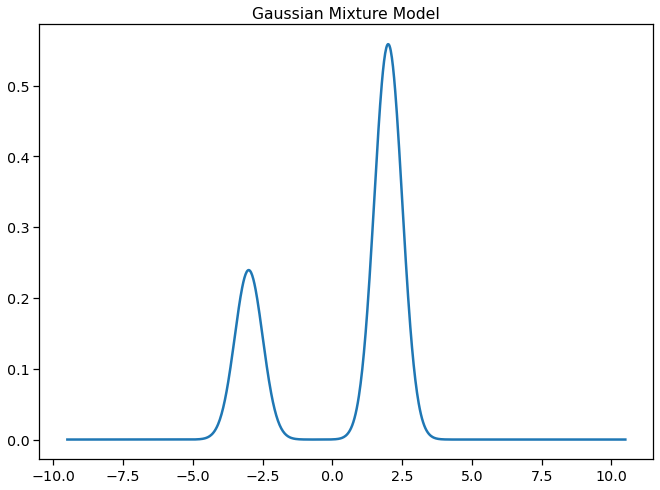

In [1]:
import numpy as rnp # regular numpy 
import scipy as rscipy # regular scipy
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import jax
import jax.numpy as np # AD numpy
import jax.scipy as scipy # AD scipy

# If you are running this code makes sure you have GPU selected as runtime type.

sns.set_context("notebook", font_scale=1.3, rc={"lines.linewidth": 2.5})

# Gaussia mixture model
class GMM:
    def __init__(self, mu, sigma, weights):
        self.mu = mu
        self.sigma = sigma
        self.weights = weights

    def pdf(self, x):
        return np.exp(self.logpdf(x))

    def logpdf(self, x):
        x = np.repeat(x, len(self.weights)).reshape(-1, len(self.weights))
        logprob = scipy.stats.norm.logpdf(x, loc=self.mu, scale=self.sigma) 
        return scipy.special.logsumexp(logprob + np.log(self.weights), axis=-1)


# define GMM posterior
loc = np.array([-3.0, 2.0])
scale = np.array([0.5, 0.5])
weight = np.array([0.3, 0.7])
gmm = GMM(loc, scale, weight)


# plot distributions
x_min = np.min(gmm.sigma)
x_max = np.max(gmm.sigma)
zs = np.linspace(x_min - 10.0, x_max + 10.0, 1000)

fig, ax = plt.subplots()
fig.set_size_inches(11, 8)
ax = sns.lineplot(zs, gmm.pdf(zs))
ax.set_title("Gaussian Mixture Model")

### Inclusive vs Exclusive KL
As we mentioned, this method mostly addresses an optimization problem, but originally the main reason to why we required MSC in the first place was because we moved from minimizing the exclusive to the inclusive KL. We gave one particular reason why one is better than the other, but to give a more qualitative view take a look at graph below. The code finds optima for the inclusive and the exlusive KL and plots the resulting parameters. The behaviour which can be appreciated is refered to as _mode seeking_ (exclusive KL) and _mode covering_ (inclusive KL),

In [2]:
def KL(p, q, zs):
    """Compute an approximate KL value

        Note that this is the formula from the traditional
        KL divergence. We are using the integration function from
        scipy to approximate.
    """
    y = p(zs) * (np.log(p(zs)) - np.log(q(zs)))
    return rscipy.integrate.trapz(y, x=zs)

def minimize_kl(model):
    """Minimize the inclusive and exclusive KL by brute force"""
    # Define a search space
    mus = np.linspace(-3.0, 3.0, 20)
    sigmas = np.linspace(0.1, 5.0, 20)
    zs = np.linspace(-5.0, 5.0, 1000)

    best_kl_inclusive = float('inf')
    best_kl_exclusive = float('inf')

    best_params_inclusive = np.zeros((2,))
    best_params_exclusive = np.zeros((2,))

    for i in range(len(mus)):
        for j in range(len(sigmas)):
            p = lambda z : model.pdf(z)
            q = lambda z : scipy.stats.norm.pdf(z, loc=mus[i], scale=sigmas[j])

            # approximate KL value
            kl_exclusive = KL(q, p, zs)
            kl_inclusive = KL(p, q, zs)

            # Update parameters if better
            if kl_exclusive < best_kl_exclusive:
                best_kl_exclusive = kl_exclusive
                best_params_exclusive = np.array([mus[i], sigmas[j]])
            
            if kl_inclusive < best_kl_inclusive:
                best_kl_inclusive = kl_inclusive
                best_params_inclusive = np.array([mus[i], sigmas[j]])

    return best_params_exclusive, best_params_inclusive

# Approximate and plot fitted distributions
exclusive_params, inclusive_params = minimize_kl(gmm) # previously defined
exclusive_pdf = lambda z : scipy.stats.norm.pdf(z, loc=exclusive_params[0], scale=exclusive_params[1])
inclusive_pdf = lambda z : scipy.stats.norm.pdf(z, loc=inclusive_params[0], scale=inclusive_params[1])

Text(0.5, 1.0, 'Minimizing Inclusive vs Exclusive KL')

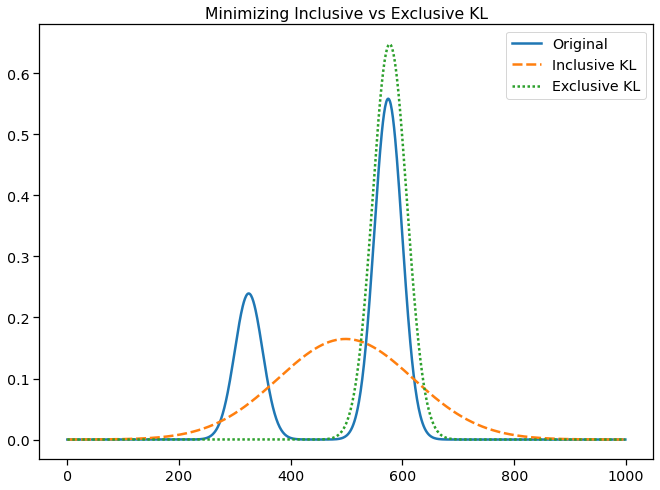

In [3]:
gmm_kl_data = pd.DataFrame({
    'Original': gmm.pdf(zs),
    'Inclusive KL': inclusive_pdf(zs),
    'Exclusive KL': exclusive_pdf(zs)
})

fig, ax = plt.subplots()
fig.set_size_inches(11, 8)
ax = sns.lineplot(data=gmm_kl_data)
ax.set_title("Minimizing Inclusive vs Exclusive KL")

## The main dish
Finally, below you can find an implementaion of the MSC algorithms as proposed by the authors. The code is heavily inspired by the original (this one is in Jax because we think is better than Autograd ;) ) we provided the link in the introduction of the notebook. We use this algorithm to fit the variational parameters and plot our results. Feel free to play around with the code. 

In [4]:
def MSC(params, posterior, key, step_size=0.5, n_samples=10, iters=10000):
    """Fit variational parameters with Markovian Score Climbing"""
    def sample_indexes(weights, key):
        uni = jax.random.uniform(key, (1,))
        b = np.cumsum(weights)
        return np.digitize(uni, b)

    def generate_samples(params, z, key):
        mu, sigma = params[0], np.exp(params[1])

        key, subkey = jax.random.split(key)
        samples = mu + sigma * jax.random.normal(subkey, (n_samples- 1,))
        samples = np.append(samples, z)

        logq = scipy.stats.norm.logpdf(samples, loc=mu, scale=sigma)
        logp = posterior.logpdf(samples)
        logw = logp - logq

        weights = np.exp(logw - np.max(logw))
        weights = weights / np.sum(weights)
        return weights, samples

    def loss(params, z, key):
        key, subkey = jax.random.split(key)
        weights, samples = generate_samples(jax.lax.stop_gradient(params), z, subkey)
        
        key, subkey = jax.random.split(key)
        index = sample_indexes(weights, subkey) 
        sample = samples[index]
        
        loc, scale = params[0], np.exp(params[1])
        logq = scipy.stats.norm.logpdf(sample, loc=loc, scale=scale)
        loss = -np.sum(logq)
        
        return loss, sample
    
    loss_grad = jax.jit(jax.grad(loss, has_aux=True))

    z_prev = 0.0
    trajectory = []
    for i in range(iters):
        trajectory.append(np.append(params, z_prev))
        key, subkey = jax.random.split(key)
        grad, z_prev = loss_grad(params, z_prev, subkey)
        params = params - step_size * grad / (i + 1) 

    trajectory = np.stack(trajectory, axis=0)
    return trajectory

def mcmc_samples(posterior, key, n_samples=10, iters=10000):
    """Sample from the true posterior with MCMC."""
    params = np.array([0.0, 0.0])
    trajectory = MSC(params, posterior, key, step_size=0, n_samples=n_samples, iters=iters)
    return trajectory[:, 2]


Text(0.5, 1.0, 'GMM Generated Samples from MSC')

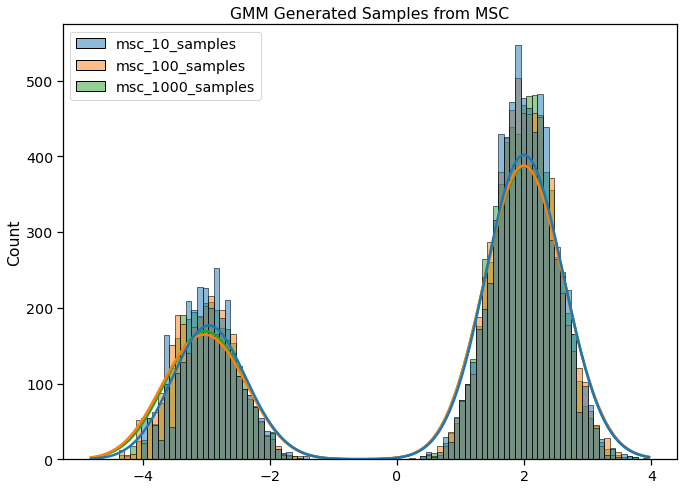

In [5]:
key = jax.random.PRNGKey(123)
generated_samples = pd.DataFrame({
    'msc_10_samples' : mcmc_samples(gmm, key, n_samples=10),
    'msc_100_samples' : mcmc_samples(gmm, key, n_samples=100),
    'msc_1000_samples' : mcmc_samples(gmm, key, n_samples=1000)
})
fig, ax = plt.subplots()
fig.set_size_inches(11, 8)
ax = sns.histplot(generated_samples, bins=100, kde=True)
ax.set_title("GMM Generated Samples from MSC")

Text(0.5, 1.0, 'Markovian Score Sampling on GMM')

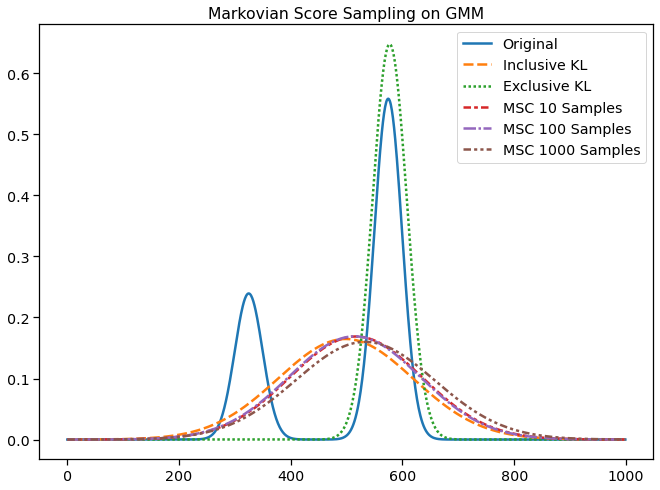

In [6]:
key = jax.random.PRNGKey(1234)
init_params = np.array([0.0, 0.0])
gmm_msc_10 = MSC(init_params, gmm, key, n_samples=10)
gmm_msc_100 = MSC(init_params, gmm, key, n_samples=100)
gmm_msc_1000 = MSC(init_params, gmm, key, n_samples=1000)

msc_10 = lambda z : scipy.stats.norm.pdf(z, loc=gmm_msc_10[-1, 0], scale=np.exp(gmm_msc_10[-1, 1])) # Log-sigma to ensure > 0
msc_100 = lambda z : scipy.stats.norm.pdf(z, loc=gmm_msc_100[-1, 0], scale=np.exp(gmm_msc_100[-1, 1]))
msc_1000 = lambda z : scipy.stats.norm.pdf(z, loc=gmm_msc_1000[-1, 0], scale=np.exp(gmm_msc_1000[-1, 1]))

# plot distributions
x_min = np.min(gmm.sigma)
x_max = np.max(gmm.sigma)
zs = np.linspace(x_min - 10.0, x_max + 10.0, 1000)

gmm_kl_data = pd.DataFrame({
    'Original': gmm.pdf(zs),
    'Inclusive KL': inclusive_pdf(zs),
    'Exclusive KL': exclusive_pdf(zs),
    'MSC 10 Samples': msc_10(zs),
    'MSC 100 Samples': msc_100(zs),
    'MSC 1000 Samples': msc_1000(zs)
})

fig, ax = plt.subplots()
fig.set_size_inches(11, 8)
ax = sns.lineplot(data=gmm_kl_data)
ax.set_title("Markovian Score Sampling on GMM")